In [1]:
!*go mod edit -replace github.com/gomlx/gomlx=/opt/janpf/Projects/gomlx.gomlx
%cd /home/janpf/work/inceptionv3

Changed directory to "/home/janpf/work/inceptionv3"


In [2]:
import (
    "log"
    "path"

    "github.com/gomlx/gomlx/ml/data"
    "github.com/gomlx/gomlx/models/inceptionv3"
)

var (
    flagDataDir = flag.String("data", "~/work/inceptionv3", "Directory to save and load downloaded and generated dataset files.")
)

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Error: %+v\n", err)
    }
}

func MustNoError[T any](value T, err error) T {
    AssertNoError(err)
    return value
}

const (
    BaselineImage = "logo.png"
)

%%
err := inceptionv3.DownloadAndUnpackWeights(*flagDataDir)
AssertNoError(err)

In [3]:
import (
        "github.com/gomlx/gomlx/models/inceptionv3"
)

%%
// name := "batch_normalization_7/batch_normalization_7/beta:0"
name := "conv2d_1/conv2d_1/kernel:0"
fPath := inceptionv3.PathToTensor(*flagDataDir, name)
f, err := os.Open(fPath)
AssertNoError(err)

local, err := tensor.Load(f)
AssertNoError(err)
fmt.Printf("%s: shape %s\n", name, local.Shape())

conv2d_1/conv2d_1/kernel:0: shape (Float32)[3 3 3 32]


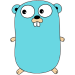

Shape()=(Float32)[75 75 3], size=16875
	> min=0, max=255, mean=211.27140740740742


In [12]:
import (
    "image"
    _ "image/png"
    "os"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/slices"
    "github.com/gomlx/gomlx/types/tensor"
    "github.com/janpfeifer/gonb/gonbui"
    timage "github.com/gomlx/gomlx/types/tensor/image"
)

func LoadImage(filePath string) (img image.Image, err error) {    
    imgFile, err := os.Open(filePath)
    if err != nil {
        return
    }
    defer imgFile.Close()

    img, _, err = image.Decode(imgFile)
    return
}

func LoadLogo() (img image.Image, err error) {    
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    logoPath := path.Join(*flagDataDir, BaselineImage)
    return LoadImage(logoPath)
}

func Hist[T shapes.Number](filePath string, local *tensor.Local) {
    f := MustNoError(os.Create(filePath))
    defer f.Close()

    
    ref := local.AcquireData()
    defer ref.Release()
    
    counts := make(map[T]int)
    flat := ref.Flat().([]T)
    for _, v := range flat {
        counts[v] = counts[v] + 1
    }
    
    keys := slices.SortedKeys(counts)
    for _, key := range keys {
        fmt.Fprintf(f, "%.5f: %d\n", key, counts[key])
    }
}

func PrintVariables(ctx *context.Context) {
    fmt.Println("\nVariables:")
    ctx.EnumerateVariables(func(v *context.Variable) {
        fmt.Printf("\t%s::%s: %s\n", v.Scope(), v.Name(), v.Shape())
    })
}

var (
    manager = BuildManager().MustDone()
    takeStats = NewExec(manager, func(x *Node) (*Node, *Node, *Node) {
        x = ConvertType(x, shapes.F64)
        max := ReduceAllMax(x)
        min := Neg(ReduceAllMax(Neg(x)))
        mean := ReduceAllMean(x)
        return min, max, mean
    })
)

func Stats(local *tensor.Local) {
    res := MustNoError(takeStats.Call(local))
    fmt.Printf("Shape()=%v, size=%d\n", local.Shape(), local.Shape().Size())
    fmt.Printf("\t> min=%v, max=%v, mean=%g\n", res[0].Value(), res[1].Value(), res[2].Value())
}

%%
img := MustNoError(LoadLogo())
gonbui.DisplayImage(img)

imgT := timage.ToTensor(shapes.F32).MaxValue(255.0).Single(img)
Stats(imgT)
Hist[float32]("/tmp/logo_go.txt", imgT)

In [36]:
import (
    "image"
    _ "image/png"
    "os"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/slices"
    "github.com/gomlx/gomlx/types/tensor"
    timage "github.com/gomlx/gomlx/types/tensor/image"
)

func ModelGraph(ctx *context.Context, img *Node) *Node {
    if img.Rank() == 3 {
        // Prepend the batch dimension.
        img = ExpandDims(img, 0)
    }
    img = inceptionv3.PreprocessImage(img, 255.0)
    logits := inceptionv3.ModelGraph(ctx.In("inceptionV3"), *flagDataDir, img)
    return logits
}

%%

img := MustNoError(LoadLogo())
imgT := timage.ToTensor(shapes.F32).MaxValue(255.0).Single(img)

ctx := context.NewContext(manager)
modelExec := context.NewExec(manager, ctx, ModelGraph)
output := MustNoError(modelExec.Call(imgT))[0].Local()


Stats(output)
Hist[float32]("output_go.txt", output)
// PrintVariables(ctx)

Shape()=(Float32)[1 1 1 2048], size=2048
	> min=0, max=5.075867176055908, mean=0.29954095975335804


In [37]:
!wc -l output_go.txt
!head -n 3 output_go.txt
!tail -n 3 output_go.txt

627 output_go.txt
0.00000: 1422
0.00292: 1
0.00431: 1
5.01186: 1
5.01694: 1
5.07587: 1


In [39]:
!diff output_py.txt output_go.txt | head -n 30

17c17
< 0.01876: 1
---
> 0.01877: 1
22c22
< 0.02434: 1
---
> 0.02433: 1
31c31
< 0.03974: 1
---
> 0.03975: 1
42c42
< 0.05291: 1
---
> 0.05292: 1
105c105
< 0.13313: 1
---
> 0.13312: 1
131c131
< 0.19045: 1
---
> 0.19046: 1
141c141
< 0.20989: 1
---
> 0.20988: 1
172c172
< 0.26702: 1
